## Hammerstein-Wiener model identification example: thermal behavior of a DC-motor

In [12]:
using OrdinaryDiffEq, Lux, Random, ComponentArrays, Plots, BenchmarkTools, StatsBase, LaTeXStrings
using Parameters: @unpack
using SciMLSensitivity, Optimization, Zygote, OptimizationFlux, LinearAlgebra

We start our investigation with building a simple baseline model. Our (known) inputs are $$ u(t) = \begin{bmatrix}i(t) \\ n(t)\end{bmatrix} $$ with $i(t)$ being the electric motor current and $n(t)$ being the motor rotational speed. Moreover, we consider a simple loss model $$P_\mathrm{v}(u(t), \vartheta(t)) = R_\mathrm{Cu}(\vartheta(t))*i^2(t) + \frac{(Li(t)n(t)\frac{2\pi}{60}\frac{\mathrm{min}}{\mathrm{s}})^2}{R_\mathrm{Fe}(\vartheta(t))}$$ with $R_\mathrm{Cu}$ being the ohmic resistance, $R_\mathrm{Fe}$ is an equivalent iron loss resistance, $L$ is the inductance and $\vartheta(t)$ is the lumped temperature of the DC-motor, i.e., the model's state ($\vartheta(t) = x(t)$). We consider linear dependencies of the resistance values based on the motor temperature.  The temperature dynamics are governed by a scalar ODE considering a single lumped motor temperature: $$\frac{\mathrm{d}}{\mathrm{d}t}x(t) = \frac{1}{C_\mathrm{Th}}\left(\frac{\vartheta_\mathrm{A}(t)-x(t)}{R_\mathrm{Th}} + P_\mathrm{v}(u(t), x(t))\right).$$

Above, $\vartheta_\mathrm{A}(t)$ is the ambient air temperature, $R_\mathrm{Th}$ is the thermal resistance between the motor and the ambient air and $C_\mathrm{Th}$ is the motor's thermal capacitance. The loss $P_\mathrm{v}(t)$ has a linear impact on the temperature dynamics, however, we assume that we only have access to the current $i(t)$ and $n(t)$, e.g., due to the lack of a power loss measurement device. Hence, the relation between $i(t)$ and $n(t)$ and $P_\mathrm{v}(t)$ is **nonlinear** which makes the system a Hammerstein model example while assuming that we can directly measure the motor temperature.

### Ground truth model

In [2]:
function simple_motor_temperature_model(dx, x, p, t)
    i(t)    = p[1](t); # motor current (time-dependent function)
    n(t)    = p[2](t); # motor speed (time-dependent function)
    ϑ_A(t)  = p[3](t); # ambient temperature (time-dependent function)
    R_Cu(t) = p[4] * (1 + p[5] * (x[1] - 20)) # copper resistance (temperature dependent with room temperature as reference)
    R_Fe(t) = p[6] * (1 + p[7] * (x[1] - 20)) # iron resistance (temperature dependent with room temperature as reference)
    L       = p[8] # inductance

    Pv(t)  = i(t)^2 * R_Cu(t) + (L * i(t) * n(t)/60*2*pi)^2 / R_Fe(t) # power loss in the motor
    
    dx[1]  = 1 / p[9] * ((-x[1] + ϑ_A(t)) / p[10] + Pv(t)) # temperature dynamics
end;

As the thermal motor behavior depends on $\{\vartheta_\mathrm{A}(t), i(t), n(t)\}$ we define some (arbitrary) signal forms for those functions.

In [3]:
i = t -> Float32(125 + 50*sin(2*pi*t/60) + 60*sin(2*pi*t/300)) # motor current (time-dependent function)
n = t -> Float32(1000 + 100*cos(2*pi*t/100) + 500*cos(2*pi*t/1000)) # motor speed (time-dependent function)
ϑ_A = t -> Float32(20 + 2*sin(2*pi*t/2000)) # ambient temperature (time-dependent function)
p = (i, n, ϑ_A, 0.016, 0.0039, 5000.0, 0.00651, 0.05, 1400.0, 0.17); # true parameters (tuple)

Next, we are going to generate some ground truth data including a mild temperature sensor noise.

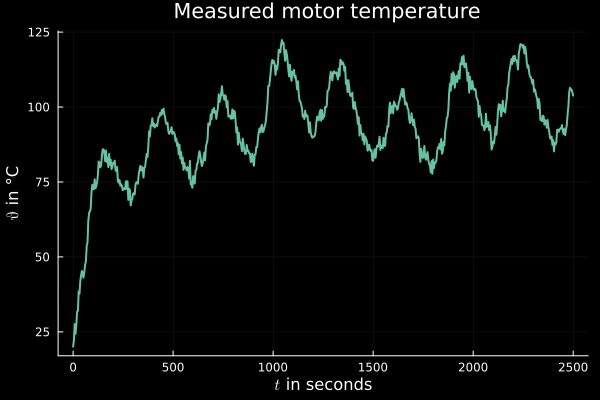

In [4]:
x0 = [20]   # initial temperature
dt = 4.0f0  # sampling time
tspan = (0.0, 2500.0) # simulation time span

prob = ODEProblem(simple_motor_temperature_model, x0, tspan, p) # define ODE problem
sol = solve(prob, Tsit5(), saveat=dt); # solve ODE problem

t = sol.t # time vector 
x = reduce(vcat,sol.u) # temperature vector
y = x .+ 1.5*randn(size(x)); # measured temperature vector incl. additive noise  

# plot results
plot(t, y, title=" Measured motor temperature", xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", 
    background_color="#000000",lw=2, palette = :Set2_5, legend = false)

### Preparation of a neural ordinary differential equation (NODE) style Hammerstein model identification

For the following identification process, we make the following assumption: $$\frac{\mathrm{d}}{\mathrm{d}t}\hat{x}(t)= \frac{1}{\hat{C}_\mathrm{Th}}\left(\frac{\vartheta_\mathrm{A}(t)-x(t)}{\hat{R}_\mathrm{Th}} + \hat{P}_{\mathrm{v}, w_{\mathrm{ANN}}}(u(t))\right).$$

Hence, we assume that we have some structural pre-knowledge on the ODE, however, we do lack detailed information on the nonlinear (static) loss inputs which is why we will make use of an artificial neural network approximation $\hat{P}_{\mathrm{v}, w_{\mathrm{ANN}}}(u(t), x(t))$. Also, the thermal parameters of the ODE are not exactly known to us and require identification.   

In order to identify the above temperature dynamics we start with defining some NODE simulation parameters.

In [19]:
NF = Float32 
x0_NODE = [NF.(y[1])] # initial temperature
tspan_NODE = NF.(tspan) # simulation time span
datasize = Int(tspan_NODE[2]/dt+1) # number of data points
tsteps_NODE = range(tspan_NODE[1], tspan_NODE[2]; length=datasize); # time vector 

To model the losses, we set up an ANN with three inputs (current, speed and temperature) and a single output (power loss). It should be noted that we utilize `sigmoid` as the output's layer activation function to ensure that the (scaled) power loss is always positive (since negative power losses would be nonphysical).

In [43]:
rng = MersenneTwister(260787) # seeding random number generator
ann = Lux.Chain(Lux.Dense(3, 10, tanh), Lux.Dense(10, 1, sigmoid)); # define neural network architecture
p_ANN, st_ANN =Lux.setup(rng, ann); # initialize neural network parameters and state

((layer_1 = (weight = Float32[-0.4739305 -0.38961452 -0.37861344; 0.65650964 -0.60525656 0.5445074; … ; -0.2769958 -0.3430645 -0.38277844; -0.0029493761 0.36286575 -0.44129267], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.5114482 -0.5607471 … 0.5868674 -0.47745523], bias = Float32[0.0;;])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

To normalize the inputs into the power loss ANN we calculate the max values such that the inputs are in the range [-1,1]. Furthermore, based on a very limited pre-knowledge about motor losses we know that the losses are temperature-dependent and will depend also on the squared motor current and squared product of the motor speed and current.

In [34]:
y_max = NF(maximum(y)) # maximum temperature
in_sqr_max = NF(maximum(map(x -> (i(x)*n(x)).^2, tsteps_NODE))) # proxy of maximum squared input power
i_sqr_max = NF(maximum(map(x -> i(x).^2, tsteps_NODE))); # maximum current squared

To scale the thermal parameters as well, we will guess some initial values of $\{\hat{R}_\mathrm{Th}, \hat{C}_\mathrm{Th}, \max(\hat{P}_\mathrm{v})\}$.

In [36]:
C_th_guess = 2000f0 # initial guess for thermal resistance (off by roughly 50 %)
R_th_guess = 0.1f0; # initial guess for thermal capacitance (off by roughly 50 %)
P_v_guess = 5000f0; # initial guess for power loss (rough estimate of the max. power losses scaled by sigmoid activation at ANN output)

Next, we build up our NODE model.

In [49]:
function simple_motor_temperature_model_learn(x, p, t)
   @unpack C_th_scale, R_th_scale, w_ANN = p # unpack parameters (using Parameters: @unpack)
   
   Pv(t)  = P_v_guess * ann([x[1] ./ y_max; i(t).^2 ./ i_sqr_max; (i(t) .* n(t)).^2 ./ in_sqr_max], w_ANN ,st_ANN)[1][1] # power loss ANN

return [1 / (C_th_scale * C_th_guess) * ((-x[1] + ϑ_A(t)) / (R_th_scale * R_th_guess) + Pv(t))] # temperature dynamics  
end;

Define a compound array with all initial parameter guesses (thermal parameters and power loss ANN parameters) and define the ODE problem.

In [44]:
params = ComponentArray(C_th_scale = 1.0f0, R_th_scale = 1.0f0, w_ANN = p_ANN); # initial guess parameters (ComponentArray)
prob_NODE = ODEProblem{false}(simple_motor_temperature_model_learn, x0_NODE, tspan_NODE, params); # define ODE problem

Set up the usual predict and loss functions.

In [39]:
function predict_NODE(p)
    reduce(vcat, solve(prob_NODE, Tsit5(); p = p, saveat = tsteps_NODE).u)
end

target = NF.(y)
function loss_NODE(p)
    return sum(abs2, target - predict_NODE(p)) 
end;

Set up the optimization problem using Optimization.jl.

In [45]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss_NODE(x), adtype)
optprob = Optimization.OptimizationProblem(optf, params)

OptimizationProblem. In-place: true
u0: ComponentVector{Float32}(C_th_scale = 1.0f0, R_th_scale = 1.0f0, w_ANN = (layer_1 = (weight = Float32[-0.4739305 -0.38961452 -0.37861344; 0.65650964 -0.60525656 0.5445074; … ; -0.2769958 -0.3430645 -0.38277844; -0.0029493761 0.36286575 -0.44129267], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = Float32[0.5114482 -0.5607471 … 0.5868674 -0.47745523], bias = Float32[0.0;;])))

Define a call back for loss value tracking during training.

In [16]:
losses = Float32[]
callback_online = function (p, l)
    push!(losses, l)
    if length(losses) % 5 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end;

Solve the Hammerstein NODE optimization problem using ADAM.

In [46]:
res = Optimization.solve(optprob, Adam(0.05);   maxiters=1000, maxtime = 120.0, callback=callback_online)

Current loss after 4115 iterations: 362721.84
Current loss after 4120 iterations: 152683.08
Current loss after 4125 iterations: 210032.72
Current loss after 4130 iterations: 68875.836
Current loss after 4135 iterations: 90089.39
Current loss after 4140 iterations: 60220.07
Current loss after 4145 iterations: 50472.406
Current loss after 4150 iterations: 50401.57
Current loss after 4155 iterations: 40514.57
Current loss after 4160 iterations: 39932.758
Current loss after 4165 iterations: 34716.766
Current loss after 4170 iterations: 32294.234
Current loss after 4175 iterations: 30629.898
Current loss after 4180 iterations: 28446.438
Current loss after 4185 iterations: 26797.855
Current loss after 4190 iterations: 26816.35
Current loss after 4195 iterations: 24044.32
Current loss after 4200 iterations: 24403.004
Current loss after 4205 iterations: 22684.91
Current loss after 4210 iterations: 20767.05
Current loss after 4215 iterations: 20667.85
Current loss after 4220 iterations: 19254.7

u: ComponentVector{Float32}(C_th_scale = 2.5470805f0, R_th_scale = 0.62869275f0, w_ANN = (layer_1 = (weight = Float32[-0.91643536 -0.54566914 -0.7880065; 0.46932387 -1.5729916 0.048928715; … ; -0.6546072 -0.39275634 -0.6709472; 0.104520254 0.006455088 -0.74771005], bias = Float32[-0.6038277; 0.34283105; … ; -0.54196537; 0.15436454;;]), layer_2 = (weight = Float32[0.72928625 -0.8603021 … 0.7229287 -0.1731194], bias = Float32[-0.35786676;;])))

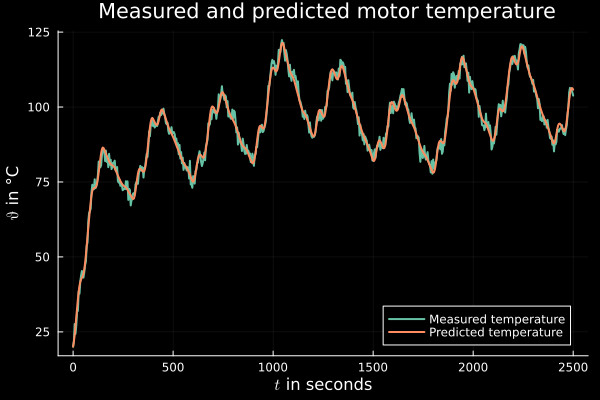

In [48]:
# plot results
plot(t, y, title=" Measured and predicted motor temperature", xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", 
    background_color="#000000",lw=2, palette = :Set2_5, label = "Measured temperature")
plot!(tsteps_NODE, predict_NODE(res.u), label="Predicted temperature", lw=2)

Although the above model accuracy in terms of the predicted vs. measured temperature profiles is quite satisfactory, the found  parameters $\{\hat{R}_\mathrm{Th}, \hat{C}_\mathrm{Th}\}$ are actually quite off:

 - $R_\mathrm{Th}=0.17$ K/W  vs.  $\hat{R}_\mathrm{Th}\approx 0.06$ K/W, 
 - $C_\mathrm{Th}=1.4$ kJ/K  vs.  $\hat{C}_\mathrm{Th}\approx 5$ kJ/K.

 Hence, the found physical parameters are inaccurate while the model flexibility of the power loss ANN seems to compensate for that. 


 ## Take away message

 **Physically-insipired NODE models (here: Hammerstein approach) can be very accurate in terms of the prediction performance, while the static nonlinearity can lead to multiple local minima in the cost space, that is, a strong physical interpretability of the found parameters is questionable.** 